In [1]:
device="cuda:0"
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
from IPython.display import HTML
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop, RandomCrop
from timm.models.efficientvit_mit import GELUTanh, ResidualBlock, build_local_block
from evit import EfficientVitLargeStageND, GroupNorm8
from codec import AutoEncoderND
from tft.wavelet import WPT2D, IWPT2D, DWT2DForward, DWT2DInverse
from tft.utils import compand, decompand
dataset = datasets.load_dataset("danjacobellis/LSDIR")

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/178 [00:00<?, ?it/s]

In [2]:
config = SimpleNamespace()
config.F = 16
config.latent_dim = 48;
config.input_channels = 3
config.encoder_depth = 6
config.λ = 1e-2
config.max_lr = 1e-3
config.min_lr = config.max_lr / 1e3
config.lr_pow = 6
config.img_size = 480
config.batch_size = 24
config.num_workers = 32
config.epochs = 36
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.checkpoint = None

In [3]:
model = AutoEncoderND(
    dim=2,
    input_channels=config.input_channels,
    J = int(config.F**0.5),
    latent_dim=config.latent_dim,
    num_res_blocks=config.encoder_depth
).to(device)

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint,weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

61.938048 M parameters


In [4]:
def collate_fn(batch):
    return torch.cat([
        PILToTensor()(
            RandomCrop(config.img_size)(sample['image'])
        ).unsqueeze(0) for sample in batch
    ]).to(torch.float)/127.5 - 1.0

In [5]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
rate_losses = []
model.train()
for i_epoch in mb:
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=collate_fn
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)

        x_hat, rate = model(x)
        rate_losses.append(rate.item())
        loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        losses.append(loss.item())
        loss+= config.λ * rate
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
    
        pb.comment = f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate_losses[-1]:.2g}, LR: {learning_rates[-1]:.2g}"

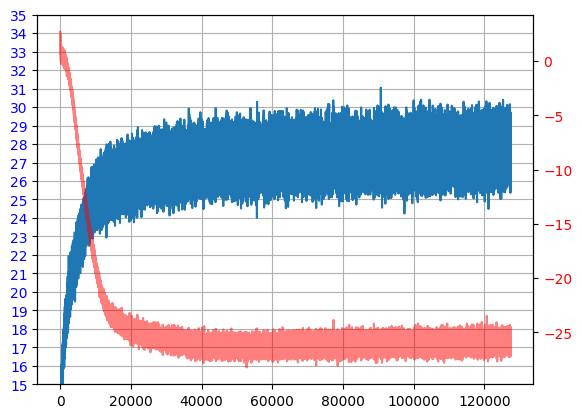

In [6]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
fig, ax1 = plt.subplots()
ax1.plot(-10*np.array(losses)+6.02)
ax1.set_yticks(range(15,36))
ax1.set_ylim([15,35])
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(-10*np.array(rate_losses), color='red', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='red')
plt.show()

In [7]:
torch.save({
    'config': config,
    'state_dict': model.state_dict()
}, '../hf/dance/dance_v0.3_rgb_f16c48.pth')

29.558 KB
26.606400974355505x compression ratio
16.0x dimension reduction
28.522784729003906 dB PSNR


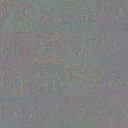

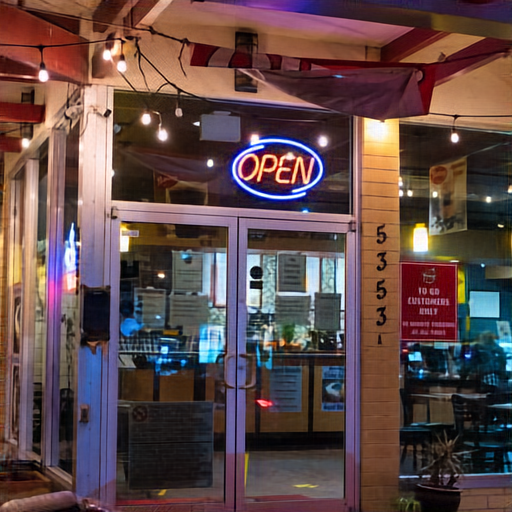

In [8]:
from walloc.walloc import latent_to_pil, pil_to_latent
model.eval()
config.img_size=512
img = CenterCrop(config.img_size)(dataset['validation'][28]['image'])
x = PILToTensor()(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0
x_orig = x[0]
orig_dim = x.numel()
with torch.no_grad():
    latent = model.encode(x).clamp(-127.49,127.49).round()
webp = latent_to_pil(latent.cpu(),n_bits=8, C=3)
buff = io.BytesIO()
webp[0].save(buff, format='WEBP', lossless=True)
size_bytes = len(buff.getbuffer())
print(f"{size_bytes/1e3} KB")
print(f"{orig_dim/size_bytes}x compression ratio")
print(f"{orig_dim/latent.numel()}x dimension reduction")
latent_decoded = pil_to_latent(webp, N=config.latent_dim, n_bits=8, C=3).to(device)
with torch.no_grad():
    x_hat = model.decode(latent_decoded).clamp(-1,1)
mse = torch.nn.functional.mse_loss(x,x_hat)
PSNR = -10*mse.log10().item() + 6.02
print(f"{PSNR} dB PSNR")
display(webp[0])
ToPILImage()(x_hat[0]/2+0.5)

bpc: 4.7737369524110225, cr: 26.813375197674507


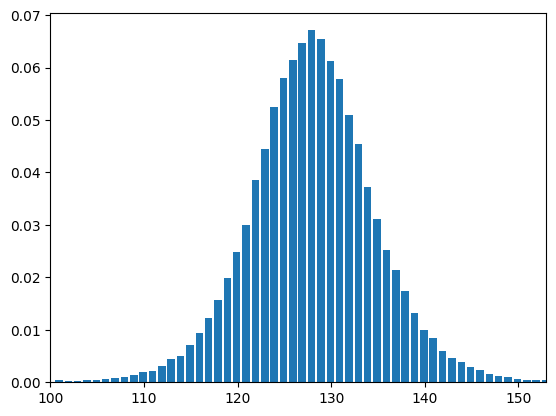

In [10]:
from torch.distributions import Categorical
x_int8 = torch.tensor(np.array(webp[0]))
h = plt.hist(x_int8.flatten(),range=(-0.5,255.5),bins=256,width=0.8,density=True)
bpc = np.log2(np.exp(1))*Categorical(torch.tensor(h[0])).entropy()
plt.xlim([100,153])
print(f"bpc: {bpc.item()}, cr: {orig_dim/latent.numel()*(8/bpc.item())}")

29.48011589050293 PSNR
28K	test.webp


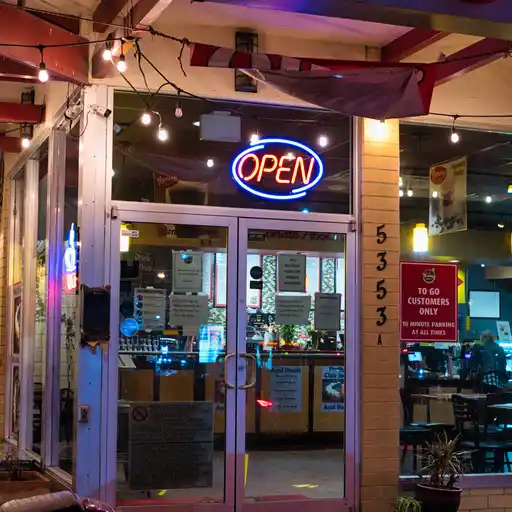

In [13]:
img.crop((0,0,config.img_size,config.img_size)).save("test.webp",quality=40)
webp = PIL.Image.open("test.webp")
MSE = torch.nn.functional.mse_loss(PILToTensor()(webp).to(torch.float)/255, x_orig.to("cpu")/2 + 0.5)
print(f"{-10*MSE.log10()} PSNR")
!du -sh test.webp
display(webp)

In [ ]:
1/(np.mean(rate_losses[-100:])/np.mean(losses[-100:]))